In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
data = pd.read_csv('/content/sample_data/ADANIGREEN_5minute.csv')

In [3]:
data.head()

,date,open,high,low,close,volume
0,2018-06-18 09:40:00,30.0,30.0,30.0,30.0,1413185
1,2018-06-18 09:45:00,30.0,30.0,30.0,30.0,0
2,2018-06-18 09:50:00,30.0,30.0,30.0,30.0,0
3,2018-06-18 09:55:00,30.0,30.0,30.0,30.0,0
4,2018-06-18 10:00:00,29.4,30.7,28.5,28.5,1887819


In [4]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

print(df)

                      date    open    high     low   close   volume
0      2018-06-18 09:40:00   30.00   30.00   30.00   30.00  1413185
1      2018-06-18 09:45:00   30.00   30.00   30.00   30.00        0
2      2018-06-18 09:50:00   30.00   30.00   30.00   30.00        0
3      2018-06-18 09:55:00   30.00   30.00   30.00   30.00        0
4      2018-06-18 10:00:00   29.40   30.70   28.50   28.50  1887819
...                    ...     ...     ...     ...     ...      ...
132161 2025-08-06 17:15:00  957.55  957.55  957.55  957.55        0
132162 2025-08-06 17:20:00  957.55  957.55  957.55  957.55        0
132163 2025-08-06 17:50:00  957.55  957.55  957.55  957.55        0
132164 2025-08-06 17:55:00  957.55  957.55  957.55  957.55        0
132165 2025-08-06 18:10:00  957.55  957.55  957.55  957.55        0

[132166 rows x 6 columns]


In [5]:
close_prices = df[['close']].values

# Scale the data (LSTM works better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

In [6]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 2  # number of time steps (window size)
X, y = create_sequences(scaled_close, SEQ_LENGTH)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (132164, 2, 1), y shape: (132164, 1)


In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/5
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0068 - val_loss: 1.8024e-04
Epoch 2/5
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 5.8916e-04 - val_loss: 7.4473e-05
Epoch 3/5
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 5.2849e-04 - val_loss: 1.2242e-04
Epoch 4/5
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 5.4324e-04 - val_loss: 2.1726e-04
Epoch 5/5
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 5.2622e-04 - val_loss: 1.3343e-04


In [10]:
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y_test)

827/827 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


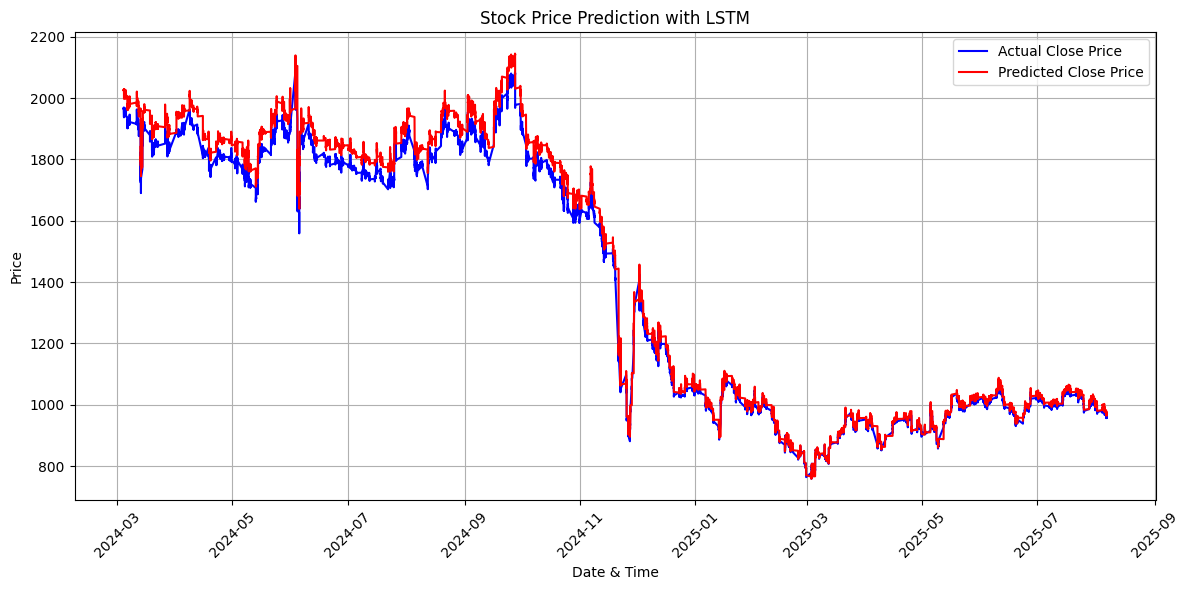

In [11]:
# -----------------------
# Step 9: Visualization with Dates
# -----------------------

# Get the corresponding dates for y_test
test_dates = df['date'][SEQ_LENGTH + split:].values  # shift by SEQ_LENGTH because of windowing

plt.figure(figsize=(12,6))
plt.plot(test_dates, actual, label='Actual Close Price', color='blue')
plt.plot(test_dates, predicted, label='Predicted Close Price', color='red')

plt.title("Stock Price Prediction with LSTM")
plt.xlabel("Date & Time")
plt.ylabel("Price")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


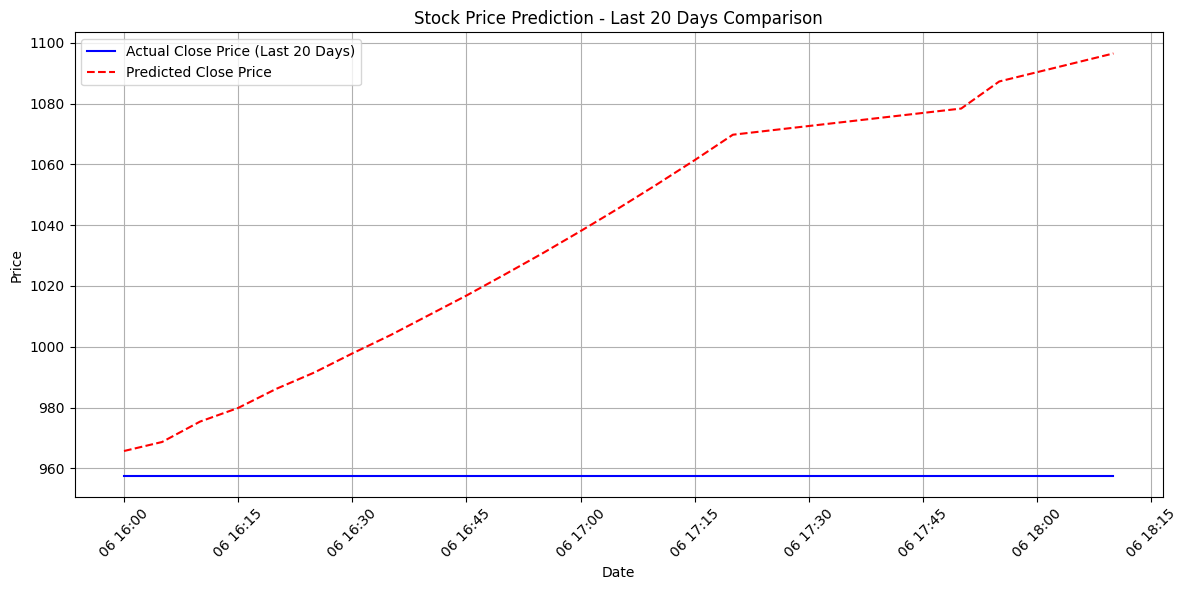

In [15]:
look_back_days = 20
last_seq_index = len(scaled_close) - look_back_days - SEQ_LENGTH
last_sequence = scaled_close[last_seq_index:last_seq_index + SEQ_LENGTH]
last_sequence = last_sequence.reshape(1, SEQ_LENGTH, 1)

predicted_last_20 = []

for _ in range(look_back_days):

    next_pred = model.predict(last_sequence, verbose=0)
    predicted_last_20.append(next_pred[0, 0])


    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    last_sequence = np.concatenate((last_sequence[:, 1:, :], next_pred_reshaped), axis=1)
predicted_last_20 = scaler.inverse_transform(np.array(predicted_last_20).reshape(-1, 1))
actual_last_20 = df['close'].values[-look_back_days:]
last_20_dates = df['date'].values[-look_back_days:]
plt.figure(figsize=(12,6))
plt.plot(last_20_dates, actual_last_20, label='Actual Close Price (Last 20 Days)', color='blue')
plt.plot(last_20_dates, predicted_last_20, label='Predicted Close Price', color='red', linestyle='dashed')

plt.title("Stock Price Prediction - Last 20 Days Comparison")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
